In [199]:
from collections import deque

def parent(i):
    return i & (i - 1)

def subtree_size(i):
    largest_child_idx = i | (i - 1)
    return largest_child_idx + 1 - i

"""
Determine the number of messages in O(n) where n is the number of messages.

Arguments:
  - ns must be a list with the number of values assigned to each rank.
    Each rank must be assigned at least 1 number!
"""
def message_count(ns):
    assert(min(ns) > 0)

    # No communication needed if there is only one rank
    if len(ns) <= 1:
        return 0

    # calculate the startIndices for each rank, add a guard element at the end.
    startIndices = deque([sum(ns[:i]) for i in range(len(ns)+1)])
    guard = startIndices[-1]
    
    # We can omit the first rank, since it does not need to send its results anywhere
    startIndices.popleft()
    
    idx = startIndices[0]
    message_count = 0
    
    while idx < guard:
        # Fetch the limits for the current rank
        begin = startIndices[0]
        end = startIndices[1]
        
        # Through the subtree_iteration we can assume that each index update yields
        # another rank-intersecting index.
        assert(parent(idx) < begin)
        message_count += 1
        
        # Update the index. If the whole subtree is local we can skip over it completely,
        # since its result will be sent in only one message. If the subtree is split over
        # one or more ranks, we update the index to the start index of the next rank.
        idx = min(idx + subtree_size(idx), end)
        
        if idx == end:
            startIndices.popleft()
    
    return message_count
    
    
# Calculate an ns array which sums n parts over m ranks.
def even_distribution(n, m):
    partsPerRank = int(n // m)
    remainder = int(n % m)
    
    return [partsPerRank + 1] * remainder + [partsPerRank] * (m - remainder)
    

In [203]:
even_distribution(5, 4)

[2, 1, 1, 1]

## Number of messages for a fixed cluster_size.

In [201]:
m = 128 # number of ranks

X = np.arange(m, 12800, dtype=np.uint)
Y = list(map(lambda n: message_count(even_distribution(n, m)), X))

<IPython.core.display.Javascript object>


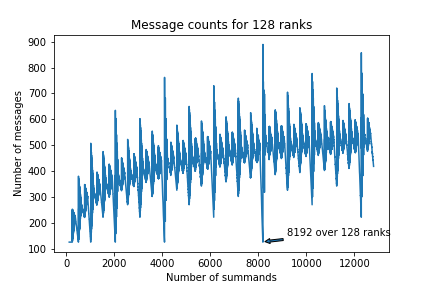

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

%matplotlib notebook

formatter1 = EngFormatter(places=0)

f = plt.figure()
ax = f.subplots(1)
plt.title(f"Message counts for {m} ranks")
ax.set_xlabel("Number of summands")
ax.set_ylabel("Number of messages")
#ax.xaxis.set_major_formatter(formatter1)

plt.annotate("8192 over 128 ranks", xy=(8192.0, 128.0), xytext=(9200.0, 150.0),
    arrowprops=dict(
        arrowstyle="simple",
))
plt.plot(X, Y)

plt.show()

## Fitting a curve

<IPython.core.display.Javascript object>


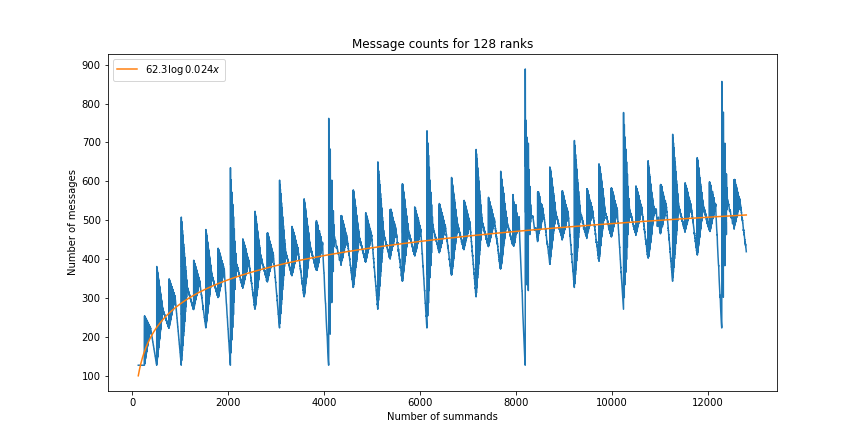

In [205]:
from scipy.optimize import curve_fit

# Try to fit a curve onto the data.
def function(x, a, b):
    return a * np.log2(b * x)

popt, pcov = curve_fit(function, X, Y, bounds=([-np.inf, 0], [np.inf, np.inf]))

f = plt.figure()
ax = f.subplots(1)
plt.title(f"Message counts for {m} ranks")
ax.set_xlabel("Number of summands")
ax.set_ylabel("Number of messages")

ax.plot(X, Y)
ax.plot(X, function(X, popt[0], popt[1]), label=f"${popt[0]:.3} \log {popt[1]:.2}x $")

ax.legend(loc='upper left')

plt.show()
plt.savefig("message_count_log.svg")